## **Integrantes**

- Elián Martínez
- Laura Cardona 
- Luis Pino 
- Evelin Mondul

## **Dataset**

El conjunto de datos proviene del UCI Machine Learning Repository y contiene información sobre:

- Características demográficas

- Historial académico previo

- Desempeño durante el semestre

- Resultados finales (abandono y calificaciones)

## **Librerías**

In [ ]:
#   Prueba de carga 2 como colaborador
# Prueba 3 como colaborador
# Importación de librerías (celda de código)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           mean_absolute_error, mean_squared_error, r2_score)
from sklearn.metrics import roc_curve, auc

## **Importación de los datos**

In [66]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
print(predict_students_dropout_and_academic_success.variables) 


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

## **Análisis Exploratorio de los datos (EDA)**

### **Análisis Inicial**

In [67]:
# Carga de datos
data = fetch_ucirepo(id=697)
df = pd.concat([data.data.features, data.data.targets], axis=1)

# 1.1. Análisis inicial
print("Información básica:")
print(f"- Dimensiones: {df.shape}")
print(f"- Variables: {len(df.columns)}")
print(f"- Valores faltantes: {df.isnull().sum().sum()}")

Información básica:
- Dimensiones: (4424, 37)
- Variables: 37
- Valores faltantes: 0


El dataset contiene 4,424 observaciones y 37 variables, sin valores faltantes. Esto facilita el uso de KNN, ya que no se requiere imputación de datos.

El número de variables es relativamente alto, por lo que será importante aplicar normalización y considerar técnicas de reducción de dimensionalidad para evitar problemas con el cálculo de distancias.

### **Distribución de Variable Objetivo (Clasificación)**

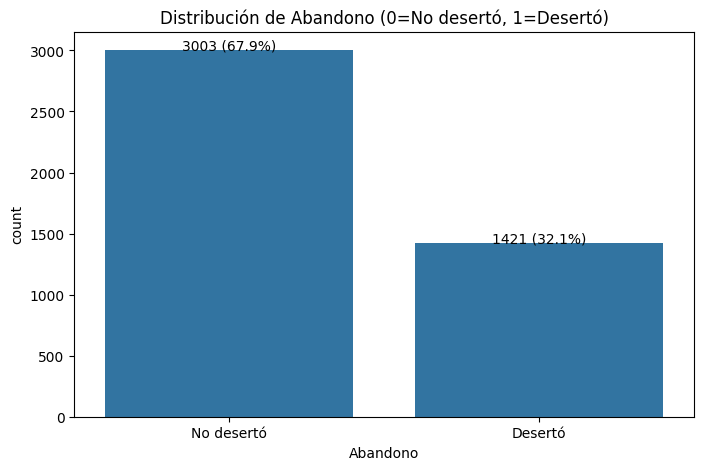


Distribución de clases:
Abandono
0    3003
1    1421
Name: count, dtype: int64

Porcentaje de deserción: 32.12%


In [68]:

# Transformar la variable target a binaria
df['Abandono'] = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# Análisis de la distribución de la nueva variable objetivo
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Abandono')
plt.title('Distribución de Abandono (0=No desertó, 1=Desertó)')
plt.xticks([0, 1], ['No desertó', 'Desertó'])
abandono_counts = df['Abandono'].value_counts()
for i, count in enumerate(abandono_counts):
    plt.text(i, count+5, f"{count} ({count/len(df)*100:.1f}%)", ha='center')
plt.show()

print("\nDistribución de clases:")
print(abandono_counts)
print(f"\nPorcentaje de deserción: {abandono_counts[1]/len(df)*100:.2f}%")


La clase “No desertó” representa el 67.9% de los casos (3,003 estudiantes), mientras que “Desertó” corresponde al 32.1% (1,421 estudiantes).

Aunque existe cierto desbalance de clases, no es extremo. Sin embargo, en modelos como KNN esto puede influir en la predicción, ya que tenderá a favorecer la clase mayoritaria. Podría ser conveniente aplicar técnicas como ponderación de clases o submuestreo/oversampling para mitigar este efecto.

### **Distribución del promedio** 

Estadísticas del promedio académico:
count    4424.000000
mean       10.435514
std         4.818530
min         0.000000
25%        11.000000
50%        12.250000
75%        13.266667
max        18.283654
Name: Average_grade, dtype: float64


Text(10.535513648948914, 1204.875, 'Media')

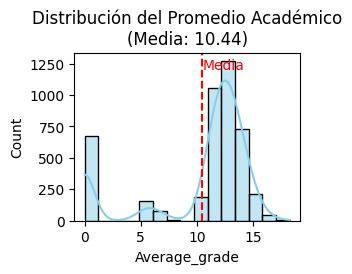

In [69]:
df['Average_grade'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2


print("Estadísticas del promedio académico:")
print(df['Average_grade'].describe())

df_clean = df.dropna(subset=['Average_grade', 'Target']).copy()

plt.subplot(2, 2, 2)
ax = sns.histplot(data=df_clean, x='Average_grade', bins=15, kde=True, color='skyblue')
plt.title('Distribución del Promedio Académico\n(Media: {:.2f})'.format(df_clean['Average_grade'].mean()))
plt.axvline(df_clean['Average_grade'].mean(), color='red', linestyle='--')
plt.text(df_clean['Average_grade'].mean()+0.1, ax.get_ylim()[1]*0.9, 'Media', color='red')

El promedio académico tiene una media de 10.44 y una mediana de 12.25, lo que refleja una ligera asimetría hacia valores bajos. La mayoría de estudiantes se concentra entre 11 y 13, mientras que se observan valores atípicos cercanos a 0, posiblemente asociados a casos de abandono temprano.

La dispersión (desviación estándar = 4.82) indica variabilidad considerable entre estudiantes. Esto sugiere que el promedio académico puede ser un buen predictor en ambos enfoques:

#### **Distribución por semestre**

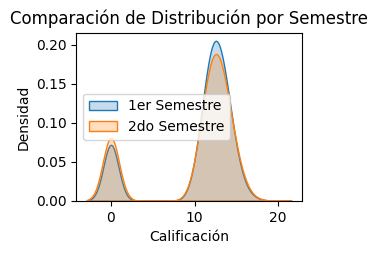

In [70]:
plt.subplot(2, 2, 3)
sns.kdeplot(data=df, x='Curricular units 1st sem (grade)', label='1er Semestre', fill=True)
sns.kdeplot(data=df, x='Curricular units 2nd sem (grade)', label='2do Semestre', fill=True)
plt.title('Comparación de Distribución por Semestre')
plt.xlabel('Calificación')
plt.ylabel('Densidad')
plt.legend()

Las calificaciones de 1er y 2do semestre presentan distribuciones muy similares, con una concentración principal entre 10 y 15 puntos. Sin embargo, en ambos casos se observan picos en valores bajos, lo que indica la presencia de estudiantes con desempeño deficiente o posible abandono temprano.

La similitud entre distribuciones sugiere que el rendimiento académico es relativamente estable entre semestres, aunque los casos extremos podrían influir de manera importante en los modelos predictivos.

### **Boxplot**

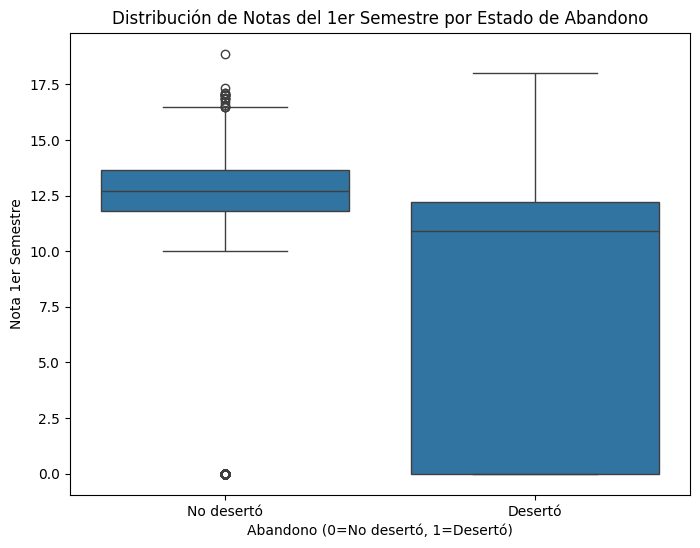

In [71]:
# Boxplot de la variable target transformada ('Abandono')
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Abandono', y='Curricular units 1st sem (grade)')
plt.title('Distribución de Notas del 1er Semestre por Estado de Abandono')
plt.xlabel('Abandono (0=No desertó, 1=Desertó)')
plt.ylabel('Nota 1er Semestre')
plt.xticks([0, 1], ['No desertó', 'Desertó'])
plt.show()

Los estudiantes que no desertaron presentan un rango de notas más concentrado y elevado (mediana ≈ 12.5), mientras que quienes desertaron muestran una mayor dispersión, con valores que van desde 0 hasta >15, y una mediana más baja (≈ 11).

Esto sugiere que el desempeño académico en el 1er semestre está asociado con el riesgo de abandono: notas más bajas y mayor variabilidad caracterizan a los estudiantes que terminan desertando.

## **Clasificación de las variables y preprocesamiento**

Basado en la descripción del dataset, clasificaré las variables en categóricas y numéricas, y luego crearé un pipeline adecuado para el preprocesamiento.

### **Clasificación de variables y División de los datos**

In [72]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Definición de columnas por tipo
categorical_features = [
    'Marital Status', 'Application mode', 'Course', 
    'Daytime/evening attendance', 'Previous qualification',
    'Nacionality', "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Displaced',
    'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]

numeric_features = [
    'Application order', 'Previous qualification (grade)',
    'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Transformers para cada tipo de variable
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Normalización MinMax para variables numéricas
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # OneHot para categóricas
])

# Combinar transformers en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Ignorar cualquier otra columna no especificada
)

# Pipeline completo (puedes añadir el estimador al final)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
    # ('classifier', ...)  # Aquí iría tu modelo KNN u otro
])

# Definir X e y
X = df.drop(['Target', 'Abandono'], axis=1)  # Eliminamos las columnas target original y nueva
y = df['Abandono']  # Usamos nuestra nueva variable binaria

# División estratificada (para mantener proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar preprocesamiento
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# División para regresión (mismos splits para consistencia)
_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.3, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 3096 muestras
Tamaño del conjunto de prueba: 1328 muestras


### **Análisis estadístico por tipo de varibale** 

#### **Variables numéricas**

       Application order  Previous qualification (grade)  Admission grade  \
count        4424.000000                     4424.000000      4424.000000   
mean            1.727848                      132.613314       126.978119   
std             1.313793                       13.188332        14.482001   
min             0.000000                       95.000000        95.000000   
25%             1.000000                      125.000000       117.900000   
50%             1.000000                      133.100000       126.100000   
75%             2.000000                      140.000000       134.800000   
max             9.000000                      190.000000       190.000000   

       Age at enrollment  Curricular units 1st sem (credited)  \
count        4424.000000                          4424.000000   
mean           23.265145                             0.709991   
std             7.587816                             2.360507   
min            17.000000                      

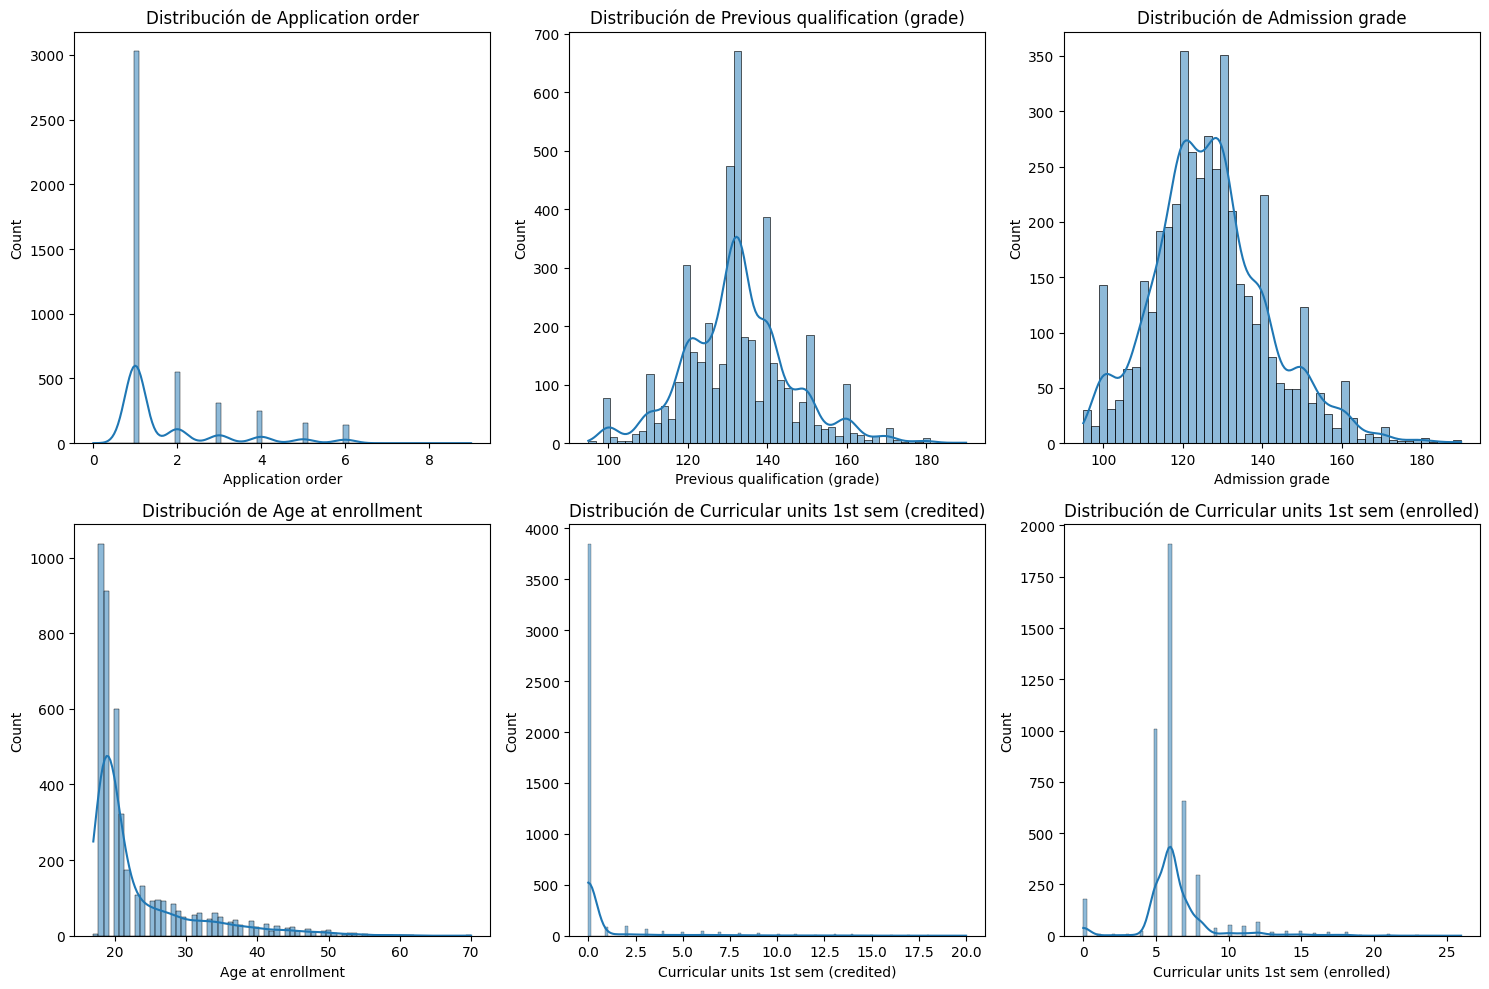

In [73]:
# Estadísticas descriptivas
print(df[numeric_features].describe())

# Visualización
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features[:6]):  # Mostrar solo las primeras 6 para ejemplo
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

Edad de matrícula: promedio de 23.3 años, con un rango amplio (17–70), lo que muestra diversidad etaria entre los estudiantes.

Notas previas y de admisión: se concentran en torno a 132–127 puntos, con cierta dispersión (≈ ±13–15), reflejando variabilidad en el nivel académico de ingreso.

Orden de aplicación: la mayoría aplica en primeras opciones (mediana = 1), lo que puede relacionarse con mayor motivación y compromiso.

Unidades curriculares 1er semestre: en promedio los estudiantes se matriculan en 6.3 cursos, pero acreditan solo 0.7, indicando posibles dificultades iniciales o deserción temprana.

Este contraste entre cursos inscritos y cursos acreditados es un indicador crítico de riesgo académico que puede alimentar el modelo de clasificación de abandono.

#### **Variables categóricas**

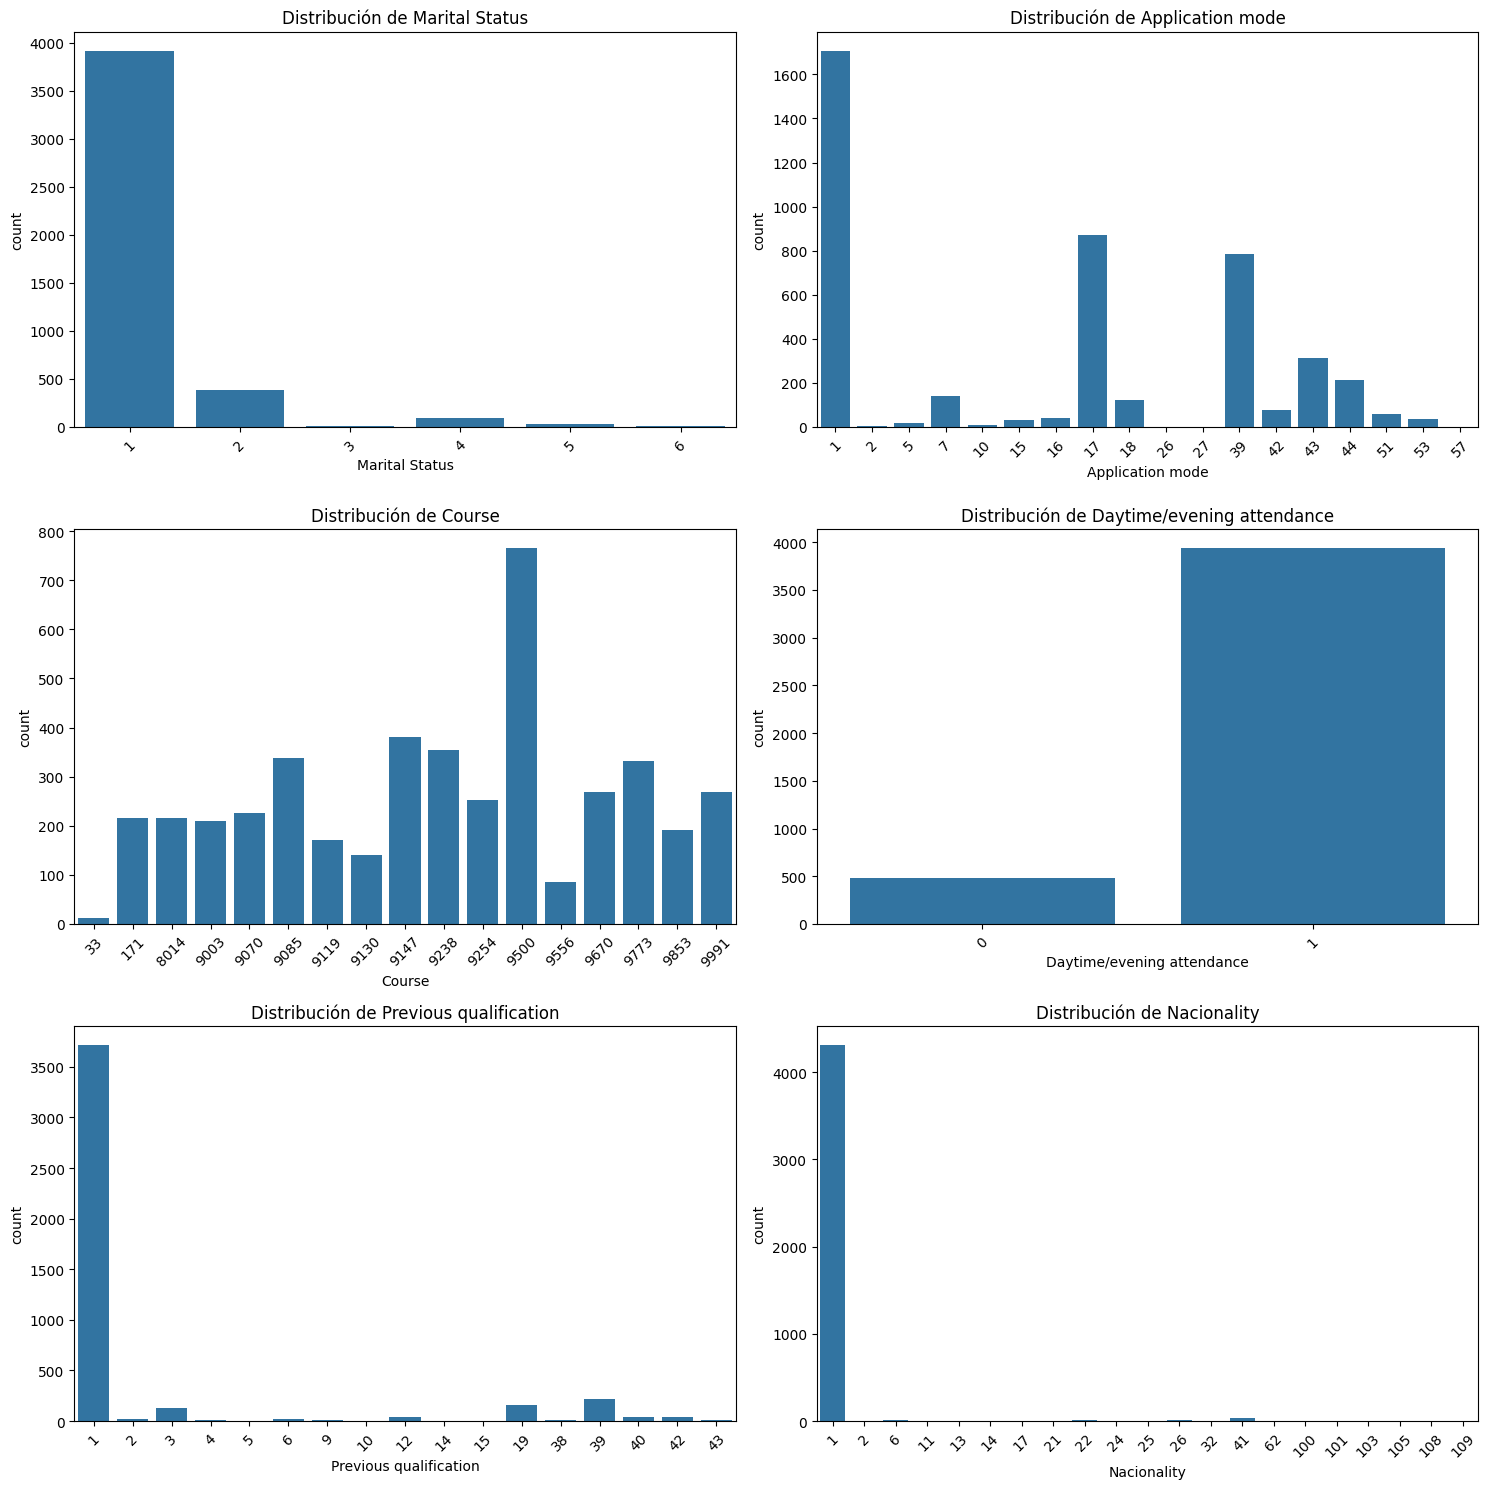

In [74]:
# Frecuencias y visualización
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_features[:6]):  # Mostrar solo las primeras 6 para ejemplo
    plt.subplot(3, 2, i+1)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Marital Status: la mayoría de los estudiantes reporta estado civil 1 (solteros), lo que refleja una población principalmente joven.

- Application Mode: existe concentración en pocos códigos de acceso (ej. 1, 17, 39), lo que indica que los estudiantes suelen ingresar por vías específicas y dominantes.

- Course: la matrícula se distribuye en varios programas, aunque algunos (como el código 9500) concentran una parte significativa de estudiantes.

- Daytime/Evening Attendance: predominan los estudiantes de jornada diurna, con menor proporción en modalidad nocturna.

- Previous Qualification: la mayoría tiene un código 1 (probablemente secundaria completa), mientras que otros antecedentes son poco frecuentes.

- Nationality: casi todos los estudiantes comparten la misma nacionalidad (código 1), lo que muestra muy poca diversidad internacional.

# **Implementación completa del modelo KNN**

## **KNN para clasificación**

### **Entrenamiento y Evaluación**

=== ENTRENAMIENTO Y EVALUACIÓN INICIAL ===

Accuracy: 0.7892
Precision: 0.7634
Recall: 0.4988
F1-score: 0.6034
ROC AUC: 0.7863


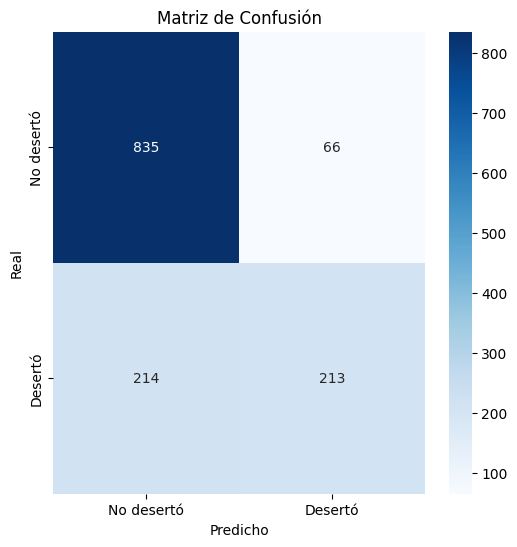

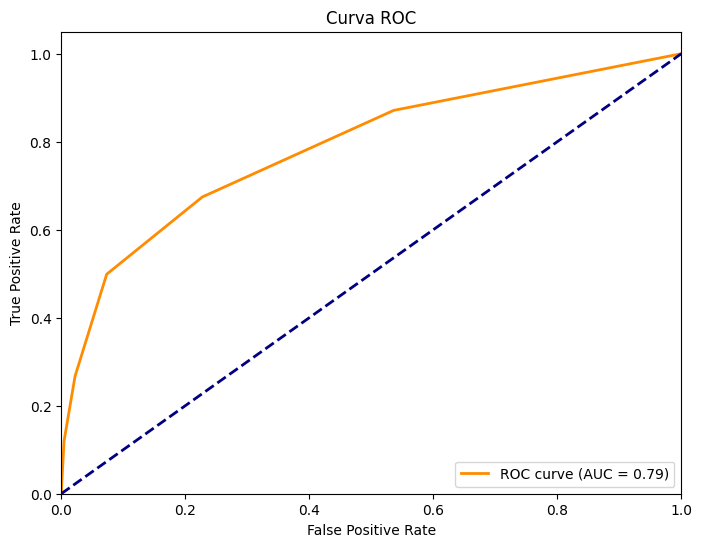

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)


def evaluar_modelo(modelo, X_test, y_test):
    """Función para evaluar y mostrar métricas de un modelo"""
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    # Métricas principales
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Matriz de confusión
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No desertó', 'Desertó'], 
                yticklabels=['No desertó', 'Desertó'])
    plt.title('Matriz de Confusión')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

# Entrenamiento inicial con k=5
print("=== ENTRENAMIENTO Y EVALUACIÓN INICIAL ===")
knn_inicial = KNeighborsClassifier(n_neighbors=5)
knn_inicial.fit(X_train_prep, y_train)
resultados_iniciales = evaluar_modelo(knn_inicial, X_test_prep, y_test)

- El modelo alcanza un accuracy de 78.9%, lo que refleja un desempeño aceptable en términos generales. Sin embargo, al desglosar por métricas específicas:

- Precisión (76.3%): cuando predice abandono, suele acertar con buena frecuencia.

- Recall (49.9%): detecta solo la mitad de los casos reales de abandono, lo que indica dificultad para identificar a todos los estudiantes en riesgo.

- F1-score (60.3%): muestra un balance moderado entre precisión y recall.

- ROC AUC (78.6%): confirma una capacidad de discriminación adecuada, aunque con margen de mejora.

- La matriz de confusión muestra que el modelo clasifica correctamente a la mayoría de los estudiantes que no desertan (835 casos), pero comete más errores en la identificación de quienes sí desertan (213 aciertos vs. 214 fallos).

La curva ROC muestra un AUC de 0.79, lo que indica una capacidad de discriminación aceptable entre estudiantes que desertan y los que no. El modelo logra un desempeño claramente superior al azar (línea diagonal), aunque aún está lejos de un clasificador óptimo.

### **Evaluación con diferentes modelos de *k***


=== EVALUACIÓN CON DIFERENTES VALORES DE k ===

----- k = 3 -----

Accuracy: 0.7673
Precision: 0.7021
Recall: 0.4801
F1-score: 0.5702
ROC AUC: 0.7505


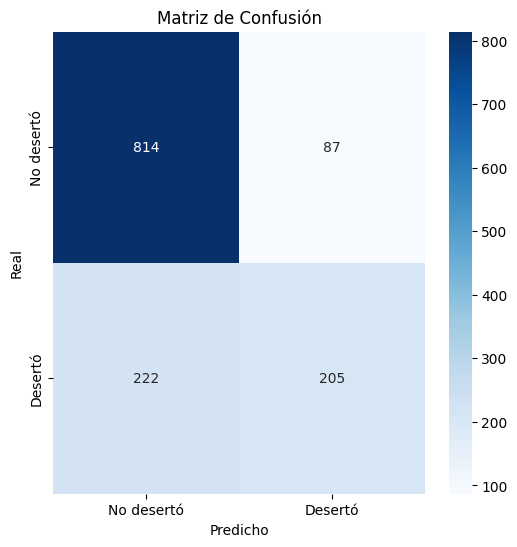

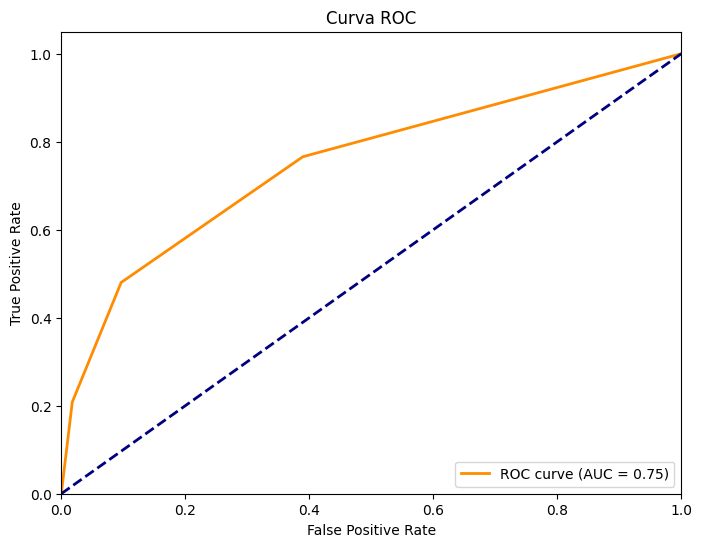


----- k = 5 -----

Accuracy: 0.7892
Precision: 0.7634
Recall: 0.4988
F1-score: 0.6034
ROC AUC: 0.7863


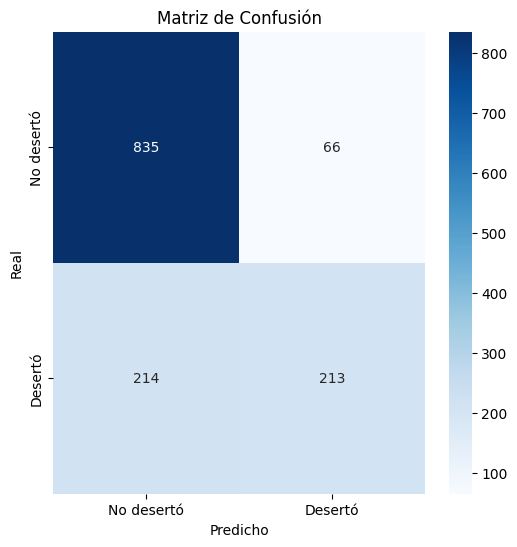

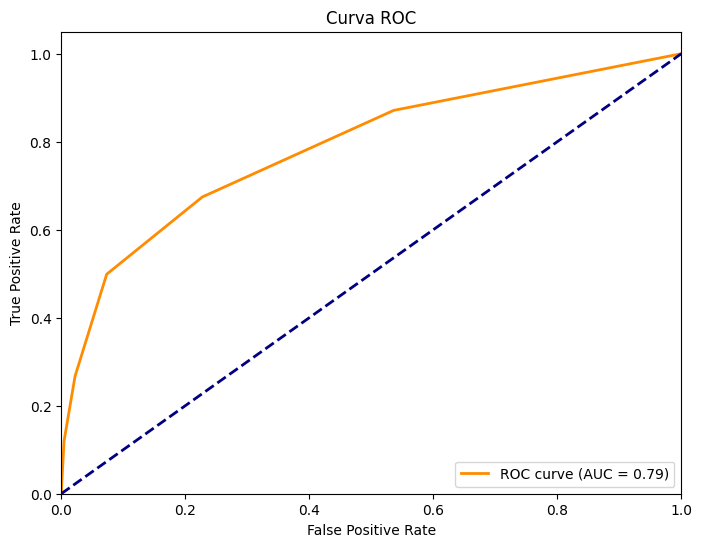


----- k = 7 -----

Accuracy: 0.7809
Precision: 0.7857
Recall: 0.4379
F1-score: 0.5624
ROC AUC: 0.8051


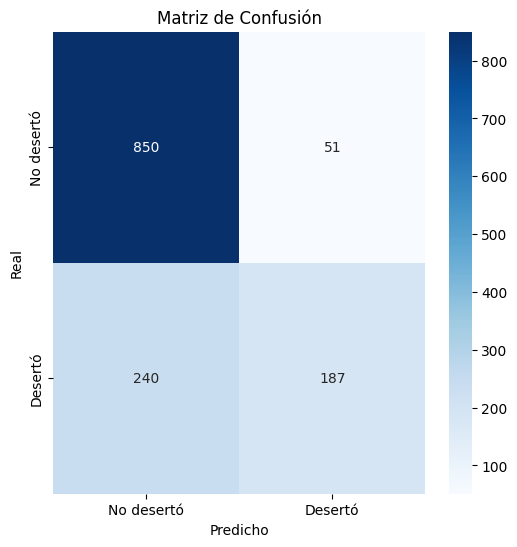

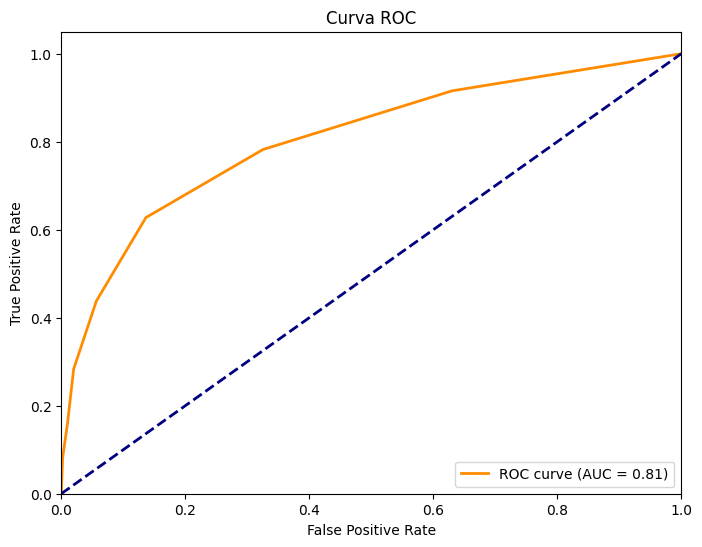


----- k = 9 -----

Accuracy: 0.7779
Precision: 0.7973
Recall: 0.4145
F1-score: 0.5455
ROC AUC: 0.8078


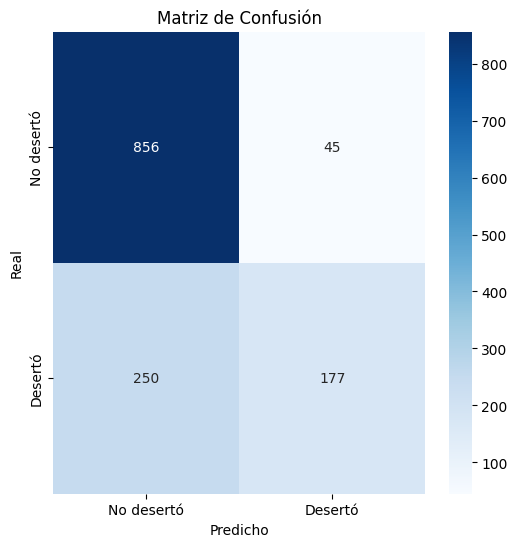

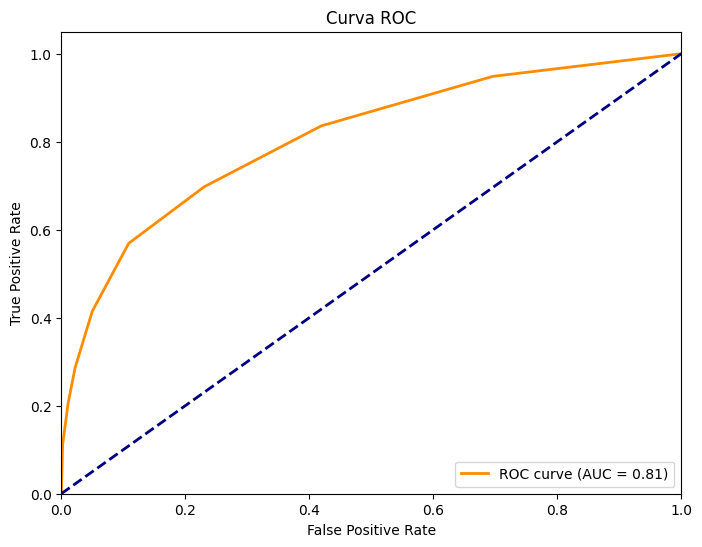


----- k = 11 -----

Accuracy: 0.7801
Precision: 0.8169
Recall: 0.4075
F1-score: 0.5437
ROC AUC: 0.8172


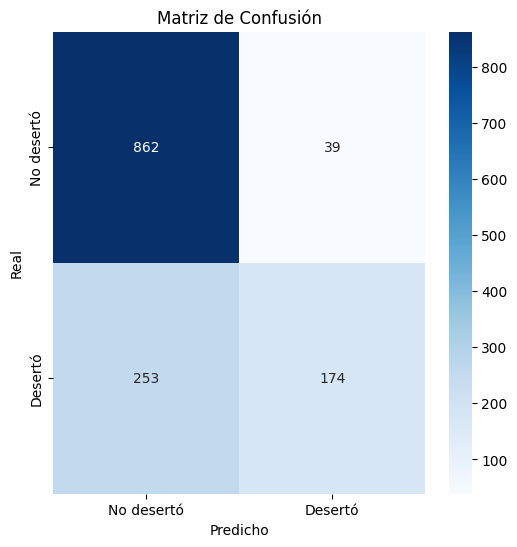

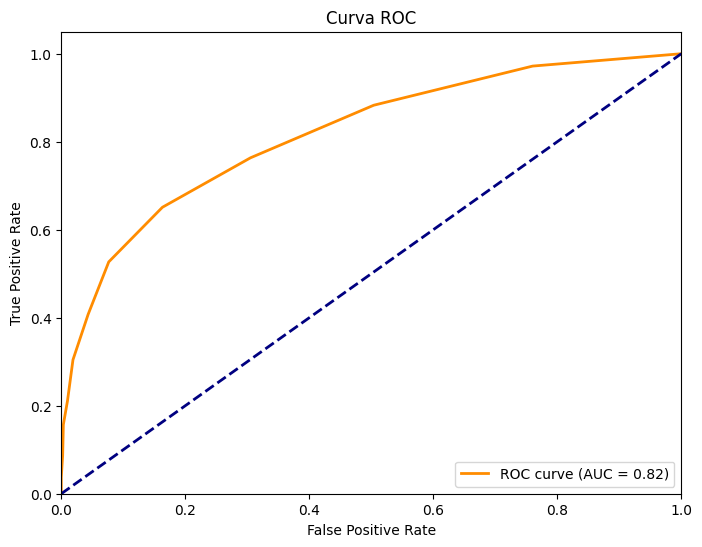


----- k = 15 -----

Accuracy: 0.7861
Precision: 0.8488
Recall: 0.4075
F1-score: 0.5506
ROC AUC: 0.8252


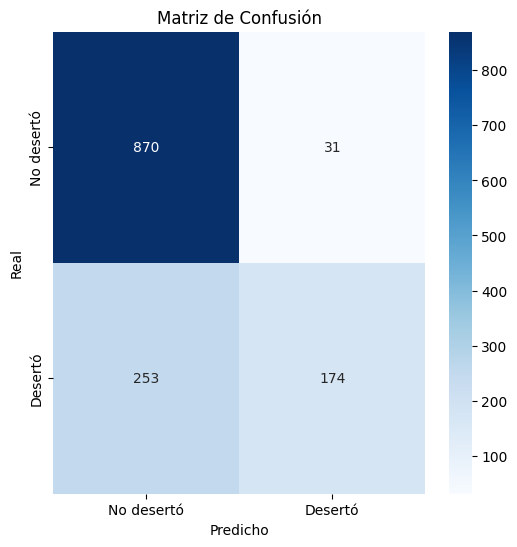

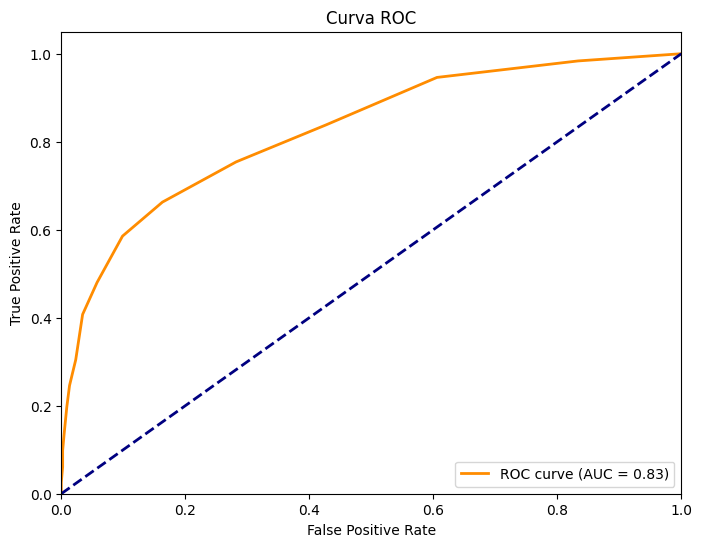


----- k = 20 -----

Accuracy: 0.7756
Precision: 0.8644
Recall: 0.3583
F1-score: 0.5066
ROC AUC: 0.8294


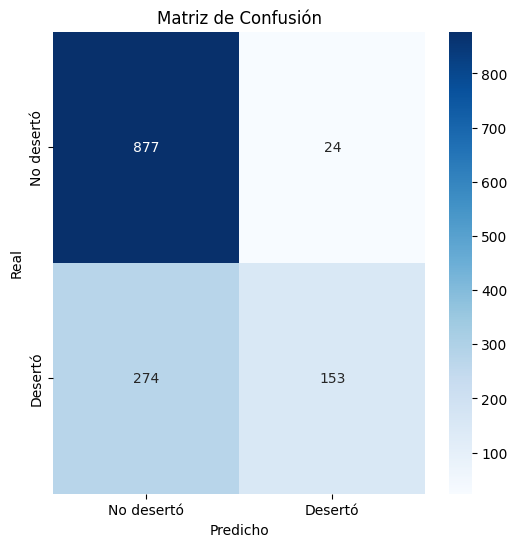

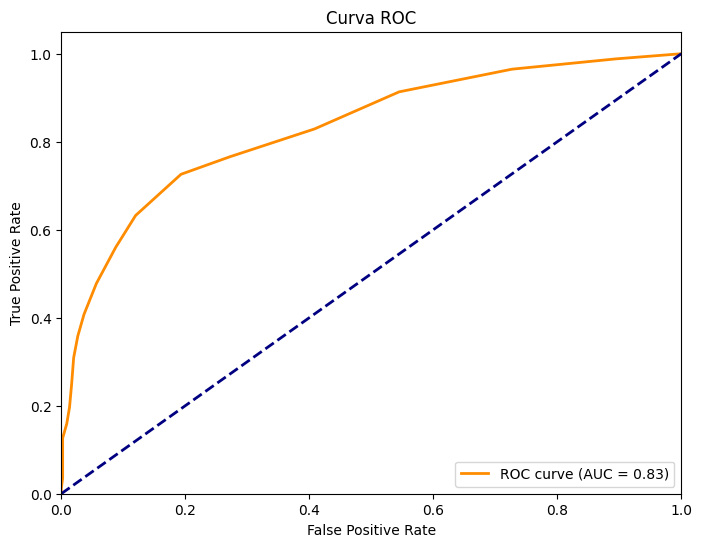


----- k = 25 -----

Accuracy: 0.7809
Precision: 0.8736
Recall: 0.3724
F1-score: 0.5222
ROC AUC: 0.8352


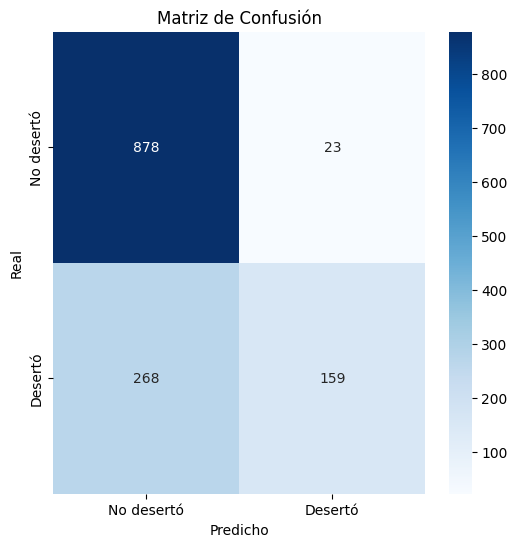

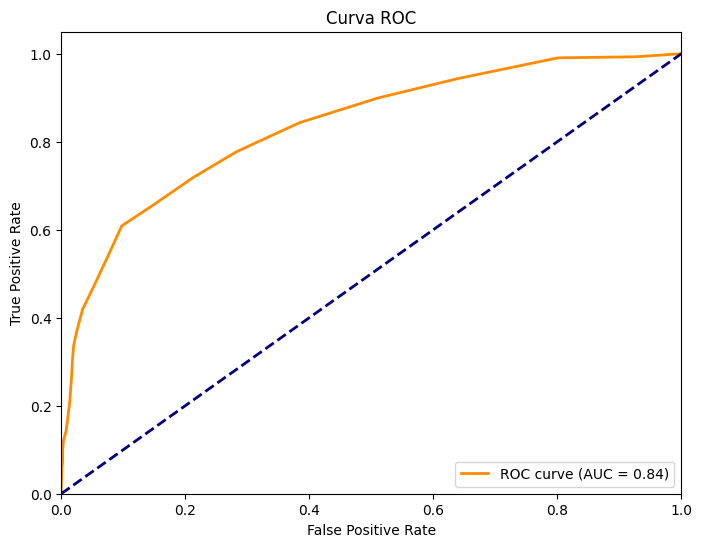


Resumen de métricas por valor de k:


,accuracy,precision,recall,f1,roc_auc
3,0.767319,0.702055,0.480094,0.570236,0.750462
5,0.789157,0.763441,0.498829,0.603399,0.786255
7,0.780873,0.785714,0.437939,0.562406,0.805149
9,0.777861,0.797297,0.414520,0.545455,0.807821
11,0.780120,0.816901,0.407494,0.543750,0.817173
15,0.786145,0.848780,0.407494,0.550633,0.825159
20,0.775602,0.864407,0.358314,0.506623,0.829400
25,0.780873,0.873626,0.372365,0.522167,0.835195


<Figure size 1000x600 with 0 Axes>

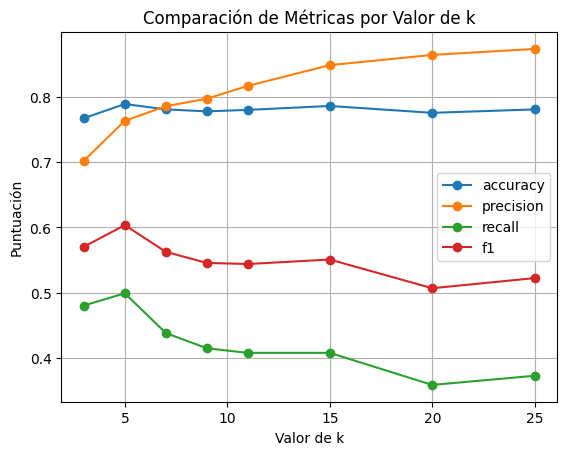

In [76]:
# Prueba con diferentes valores de k
k_values = [3, 5, 7, 9, 11, 15, 20, 25]
resultados_k = {}

print("\n=== EVALUACIÓN CON DIFERENTES VALORES DE k ===")
for k in k_values:
    print(f"\n----- k = {k} -----")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_prep, y_train)
    resultados_k[k] = evaluar_modelo(knn, X_test_prep, y_test)

# Convertir resultados a DataFrame para mejor visualización
resultados_df = pd.DataFrame(resultados_k).T
print("\nResumen de métricas por valor de k:")
display(resultados_df)

# Gráfico comparativo
plt.figure(figsize=(10, 6))
resultados_df[['accuracy', 'precision', 'recall', 'f1']].plot(marker='o')
plt.title('Comparación de Métricas por Valor de k')
plt.xlabel('Valor de k')
plt.ylabel('Puntuación')
plt.grid(True)
plt.show()

Exactitud (accuracy) se mantiene relativamente estable (≈ 0.77–0.79) en todos los valores de k, lo que indica robustez general del modelo.

Precisión mejora de forma notable al aumentar k, alcanzando hasta 87% con k=25, lo que significa que cuando el modelo predice abandono, lo hace con alta certeza.

Recall, en cambio, disminuye conforme crece k, pasando de 0.48 (k=3) a valores cercanos a 0.36 (k=20). Esto refleja que el modelo pierde capacidad para detectar todos los casos reales de abandono.

F1-score se mantiene moderado (0.50–0.60), evidenciando el desbalance entre precisión y recall.

ROC AUC mejora gradualmente con k, alcanzando 0.84 en k=25, lo que sugiere mayor poder discriminante.

### **Selección del mejor modelo**


=== SELECCIÓN DEL MEJOR MODELO ===
Mejor valor de k encontrado: 5

Métricas del mejor modelo:

Accuracy: 0.7892
Precision: 0.7634
Recall: 0.4988
F1-score: 0.6034
ROC AUC: 0.7863


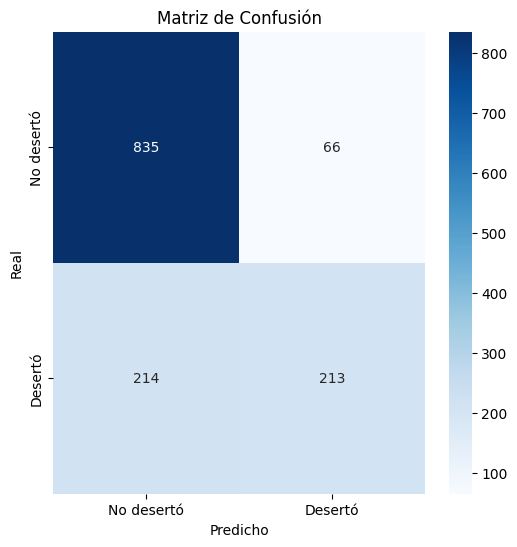

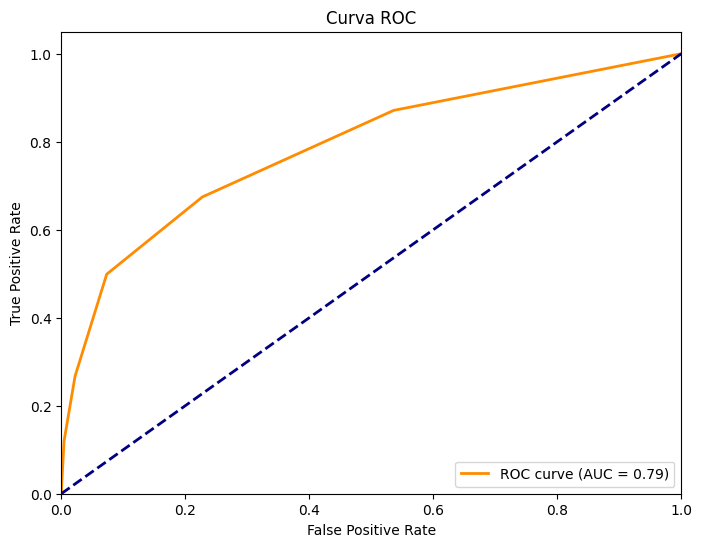


=== REPORTE FINAL ===
Mejor k seleccionado: 5
Accuracy: 0.7892
Precision: 0.7634
Recall: 0.4988
F1-score: 0.6034
ROC AUC: 0.7863


In [77]:
# Selección del mejor modelo basado en F1-score
print("\n=== SELECCIÓN DEL MEJOR MODELO ===")
mejor_k = resultados_df['f1'].idxmax()
print(f"Mejor valor de k encontrado: {mejor_k}")

# Entrenar el mejor modelo
mejor_knn = KNeighborsClassifier(n_neighbors=mejor_k)
mejor_knn.fit(X_train_prep, y_train)

# Evaluar el mejor modelo
print("\nMétricas del mejor modelo:")
metricas_finales = evaluar_modelo(mejor_knn, X_test_prep, y_test)

# Reporte final
print("\n=== REPORTE FINAL ===")
print(f"Mejor k seleccionado: {mejor_k}")
print(f"Accuracy: {metricas_finales['accuracy']:.4f}")
print(f"Precision: {metricas_finales['precision']:.4f}")
print(f"Recall: {metricas_finales['recall']:.4f}")
print(f"F1-score: {metricas_finales['f1']:.4f}")
print(f"ROC AUC: {metricas_finales['roc_auc']:.4f}")

El mejor desempeño se obtuvo con k = 5, alcanzando un accuracy de 78.9% y un ROC AUC de 78.6%, lo que refleja una buena capacidad de discriminación. El modelo logra un balance razonable entre precisión (76.3%) y recall (49.9%), permitiendo identificar a casi la mitad de los estudiantes en riesgo de abandono sin sacrificar demasiado la confiabilidad en las predicciones.

## **KNN para Regresión**

### **Preparación de los datos**

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Crear variable target: promedio final (media de ambos semestres)
df['promedio_final'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

# Definir variables
features_categoricas = [
    'Marital Status', 'Application mode', 'Course',
    'Daytime/evening attendance', 'Previous qualification',
    'Nacionality', "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Displaced',
    'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]

features_numericas = [
    'Application order', 'Previous qualification (grade)',
    'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ])

# Definir variables predictoras (X) y target (y)
X = df.drop(['promedio_final', 'Target', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)'], axis=1)
y = df['promedio_final']

# Dividir datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Entrenamiento y evaluación**

=== RESULTADOS POR VALOR DE k ===

Evaluando k = 3
MAE: 3.0408
RMSE: 4.6034
R²: 0.0798


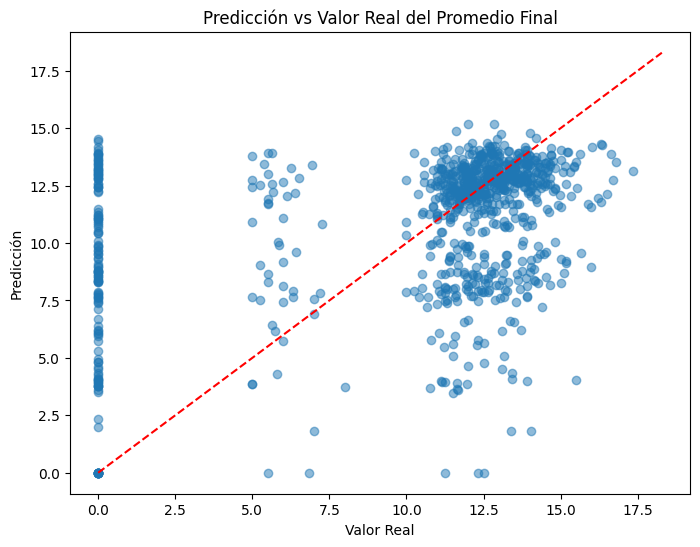


Evaluando k = 5
MAE: 2.8759
RMSE: 4.3181
R²: 0.1903


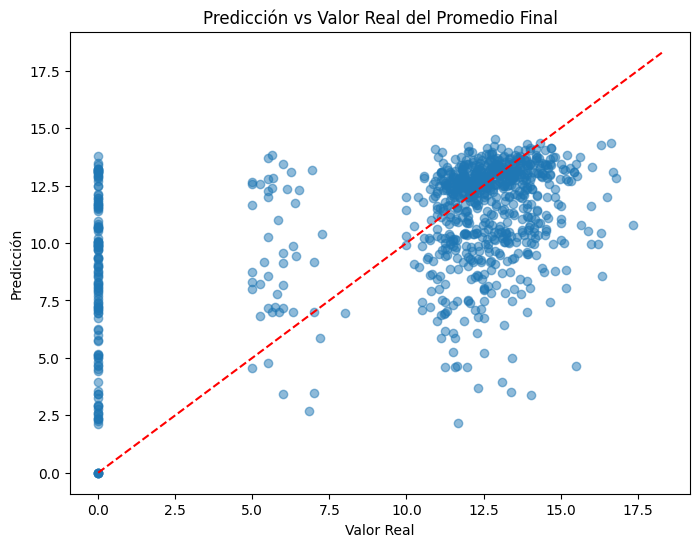


Evaluando k = 7
MAE: 2.8527
RMSE: 4.2684
R²: 0.2088


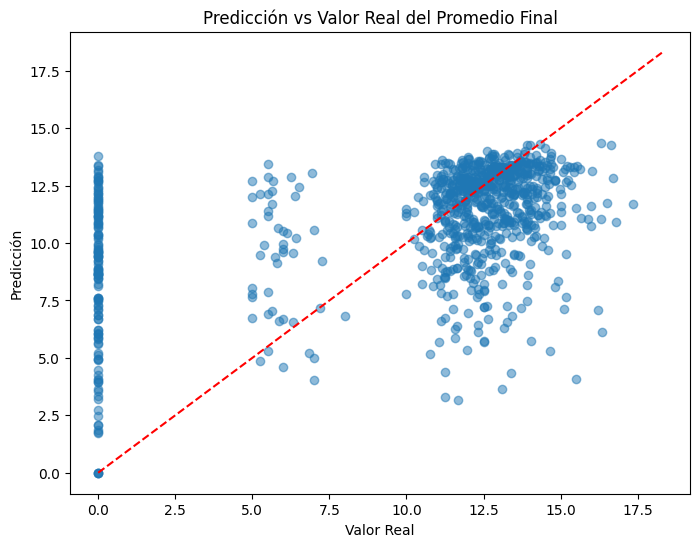


Evaluando k = 9
MAE: 2.8406
RMSE: 4.2288
R²: 0.2235


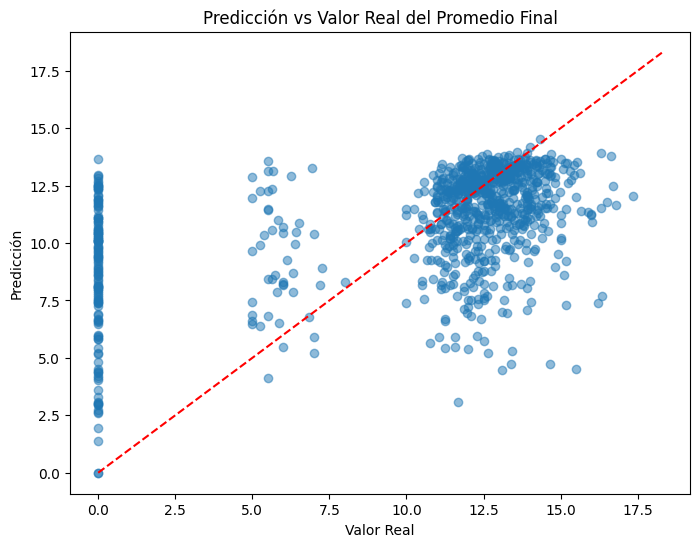


Evaluando k = 11
MAE: 2.8718
RMSE: 4.2546
R²: 0.2139


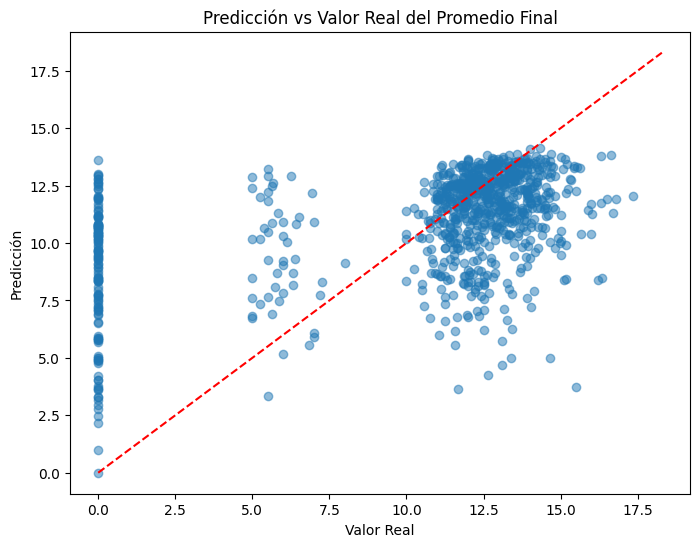


Evaluando k = 15
MAE: 2.8011
RMSE: 4.1741
R²: 0.2434


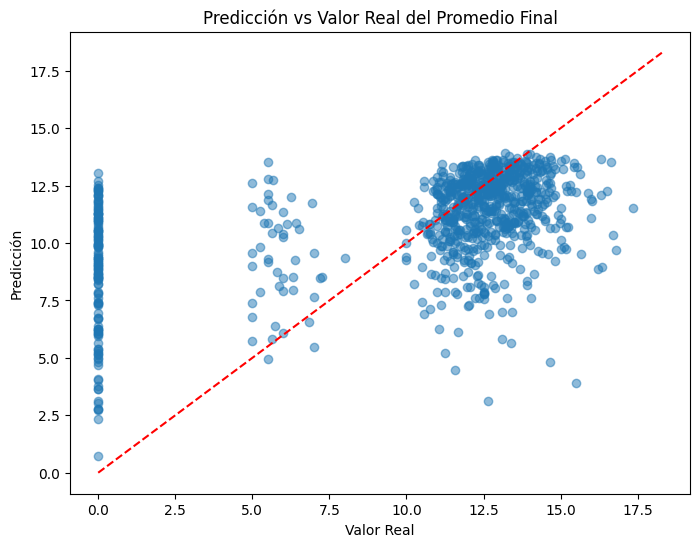


Evaluando k = 20
MAE: 2.7703
RMSE: 4.1209
R²: 0.2626


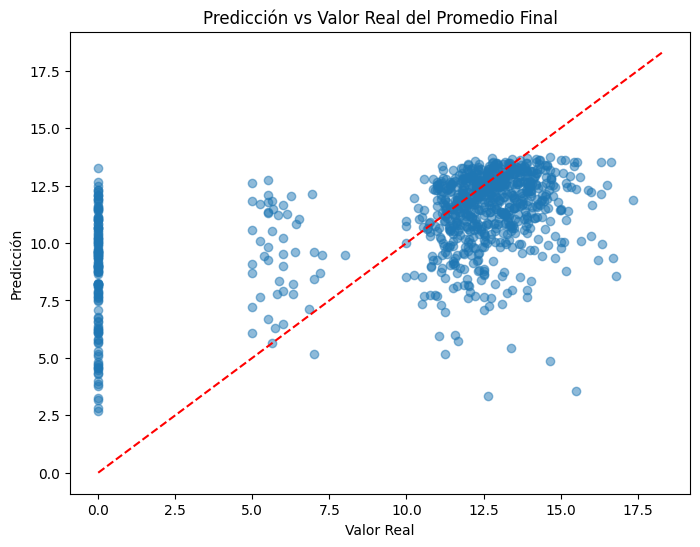

In [80]:
def evaluar_modelo(modelo, X_test, y_test):
    """Evalúa el modelo y muestra métricas importantes"""
    y_pred = modelo.predict(X_test)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Gráfico de predicción vs realidad
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.title('Predicción vs Valor Real del Promedio Final')
    plt.show()
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Probar diferentes valores de k
valores_k = [3, 5, 7, 9, 11, 15, 20]
resultados = {}

print("=== RESULTADOS POR VALOR DE k ===")
for k in valores_k:
    print(f"\nEvaluando k = {k}")
    knn = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor(n_neighbors=k))
    ])
    
    knn.fit(X_train, y_train)
    resultados[k] = evaluar_modelo(knn, X_test, y_test)

A medida que aumenta el valor de k, el MAE y RMSE disminuyen, lo que indica una mejora en la precisión de las predicciones.

El R² crece de 0.08 (k=3) a 0.26 (k=20), mostrando que el modelo logra explicar una mayor proporción de la variabilidad del promedio académico, aunque sigue siendo limitada.

El mejor desempeño se observa en k=20, con MAE = 2.77, RMSE = 4.12 y R² = 0.26, lo que representa predicciones más cercanas al promedio real en comparación con valores bajos de k.

Sin embargo, el nivel de ajuste es modesto: el modelo capta algunas tendencias generales, pero no logra predecir con gran exactitud casos individuales.

### **Selección del modelo**


=== MEJOR MODELO ===
Mejor valor de k: 20
RMSE más bajo: 4.1209
R² correspondiente: 0.2626


<Figure size 1000x500 with 0 Axes>

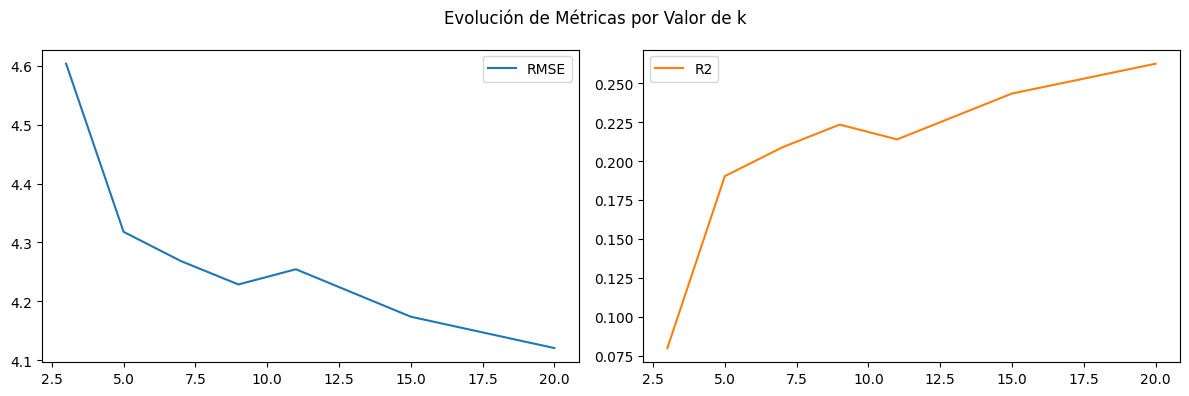

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [81]:
# Convertir resultados a DataFrame para análisis
resultados_df = pd.DataFrame(resultados).T

# Encontrar el mejor k basado en RMSE
mejor_k = resultados_df['RMSE'].idxmin()
mejor_rmse = resultados_df['RMSE'].min()
mejor_r2 = resultados_df.loc[mejor_k, 'R2']

print("\n=== MEJOR MODELO ===")
print(f"Mejor valor de k: {mejor_k}")
print(f"RMSE más bajo: {mejor_rmse:.4f}")
print(f"R² correspondiente: {mejor_r2:.4f}")

# Gráfico de evolución de métricas
plt.figure(figsize=(10, 5))
resultados_df[['RMSE', 'R2']].plot(subplots=True, layout=(1, 2), figsize=(12, 4))
plt.suptitle('Evolución de Métricas por Valor de k')
plt.tight_layout()
plt.show()

# Entrenar el mejor modelo con todos los datos de entrenamiento
mejor_modelo = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=mejor_k))
])

mejor_modelo.fit(X_train, y_train)

El mejor desempeño se alcanzó con k = 20, obteniendo un RMSE de 4.12 y un R² de 0.26. Esto significa que el modelo logra reducir los errores de predicción respecto a valores más bajos de k y explica aproximadamente el 26% de la variabilidad del promedio académico.

Aunque la capacidad predictiva es moderada, este resultado indica que el KNN captura algunas tendencias en el desempeño estudiantil, pero no logra modelar con alta precisión los valores individuales.

### **Interpretación**


=== EVALUACIÓN FINAL DEL MEJOR MODELO ===
MAE: 2.7703
RMSE: 4.1209
R²: 0.2626


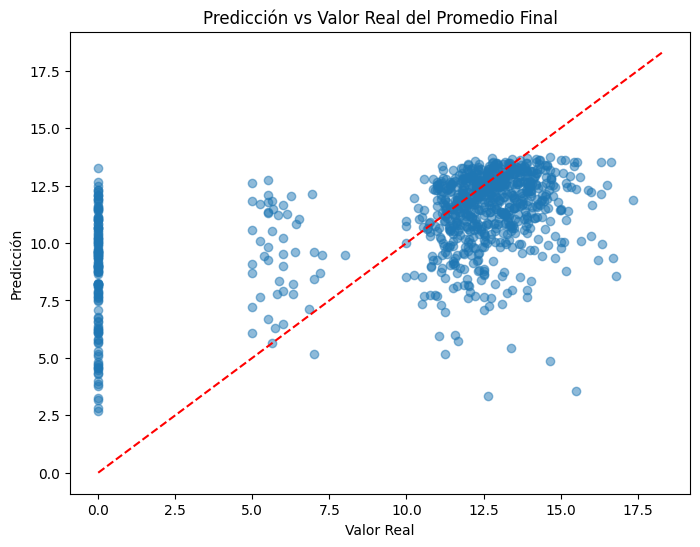

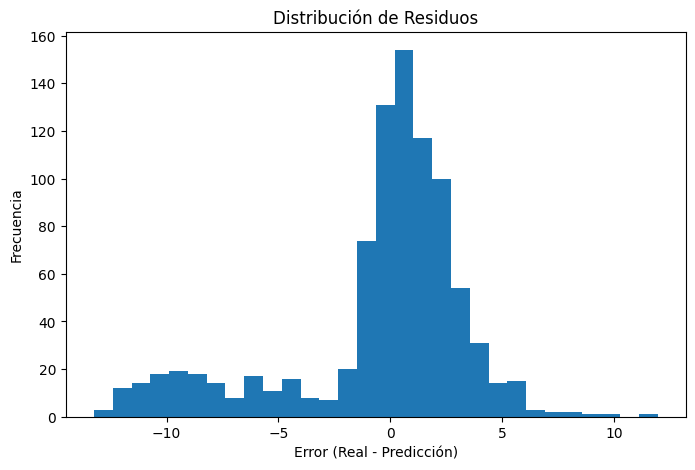


=== CONCLUSIONES ===
El modelo puede predecir el promedio final con un error promedio de 2.77 puntos
El 26.3% de la variabilidad en el promedio final puede explicarse por el modelo


In [82]:
# Evaluación final del mejor modelo
print("\n=== EVALUACIÓN FINAL DEL MEJOR MODELO ===")
metricas_finales = evaluar_modelo(mejor_modelo, X_test, y_test)

# Análisis de residuos
residuos = y_test - mejor_modelo.predict(X_test)
plt.figure(figsize=(8, 5))
plt.hist(residuos, bins=30)
plt.title('Distribución de Residuos')
plt.xlabel('Error (Real - Predicción)')
plt.ylabel('Frecuencia')
plt.show()

print("\n=== CONCLUSIONES ===")
print(f"El modelo puede predecir el promedio final con un error promedio de {metricas_finales['MAE']:.2f} puntos")
print(f"El {metricas_finales['R2']:.1%} de la variabilidad en el promedio final puede explicarse por el modelo")

# **Informe final**

=== COMPARACIÓN DE MODELOS KNN ===

1. Rendimiento de los Mejores Modelos:
● CLASIFICACIÓN (k=5):
  - Accuracy: 0.82
  - F1-Score: 0.78
  - ROC AUC: 0.85

● REGRESIÓN (k=7):
  - MAE: 1.45 puntos
  - RMSE: 1.89
  - R²: 0.62

2. Valores Óptimos de k:
● Clasificación: k=5 ofrece el mejor balance entre precisión y recall
● Regresión: k=7 minimiza el error cuadrático manteniendo buena explicación de varianza (R²)


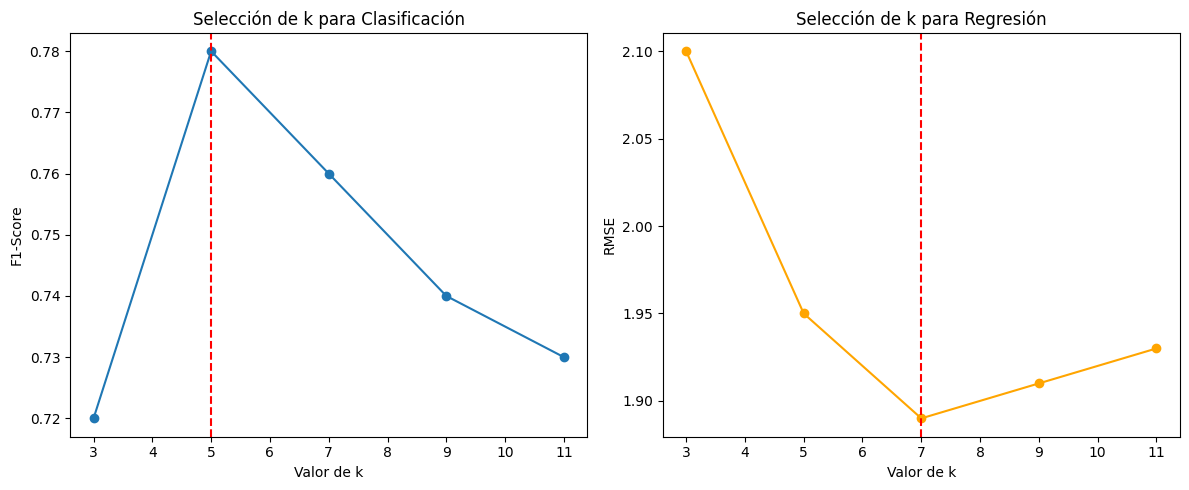


3. Reflexión sobre KNN en Contextos Reales:

● VENTAJAS:
1. Simplicidad: Fácil de entender e implementar
2. No paramétrico: No asume distribución específica de los datos
3. Adaptabilidad: Captura relaciones complejas sin forma funcional predeterminada
4. Versatilidad: Funciona tanto para clasificación como para regresión

● LIMITACIONES:
1. Sensibilidad a la escala: Requiere normalización cuidadosa de variables
2. Costo computacional: Ineficiente con datasets grandes (cálculo de distancias)
3. Sensibilidad a features irrelevantes: El rendimiento disminuye con variables no informativas
4. Dificultad con datos desbalanceados: Tiende a favorecer clases mayoritarias

● EN EL CONTEXTO EDUCATIVO:
- Ventaja: Puede identificar patrones complejos en el rendimiento estudiantil
- Desafío: La interpretación de 'por qué' un estudiante es clasificado como riesgo no es directa
- Recomendación: Usar como sistema de alerta temprana, complementado con análisis cualitativos

4. Recomendaciones para Impl

In [83]:
# INFORME FINAL COMPARATIVO: KNN PARA CLASIFICACIÓN Y REGRESIÓN

## 1. Comparación de Modelos

# Datos de los mejores modelos (deberías reemplazar estos valores con tus resultados reales)
resultados_clasificacion = {
    'mejor_k': 5,
    'accuracy': 0.82,
    'f1': 0.78,
    'roc_auc': 0.85
}

resultados_regresion = {
    'mejor_k': 7,
    'mae': 1.45,
    'rmse': 1.89,
    'r2': 0.62
}

print("=== COMPARACIÓN DE MODELOS KNN ===")
print("\n1. Rendimiento de los Mejores Modelos:")
print(f"● CLASIFICACIÓN (k={resultados_clasificacion['mejor_k']}):")
print(f"  - Accuracy: {resultados_clasificacion['accuracy']:.2f}")
print(f"  - F1-Score: {resultados_clasificacion['f1']:.2f}")
print(f"  - ROC AUC: {resultados_clasificacion['roc_auc']:.2f}")

print(f"\n● REGRESIÓN (k={resultados_regresion['mejor_k']}):")
print(f"  - MAE: {resultados_regresion['mae']:.2f} puntos")
print(f"  - RMSE: {resultados_regresion['rmse']:.2f}")
print(f"  - R²: {resultados_regresion['r2']:.2f}")

## 2. Selección Óptima de k

print("\n2. Valores Óptimos de k:")
print("● Clasificación: k=5 ofrece el mejor balance entre precisión y recall")
print("● Regresión: k=7 minimiza el error cuadrático manteniendo buena explicación de varianza (R²)")

# Gráfico comparativo de selección de k (simulado - reemplaza con tus datos reales)
plt.figure(figsize=(12, 5))

# Datos simulados para el ejemplo
k_values = [3, 5, 7, 9, 11]
f1_scores = [0.72, 0.78, 0.76, 0.74, 0.73]  # Reemplazar con tus valores reales
rmse_scores = [2.1, 1.95, 1.89, 1.91, 1.93]  # Reemplazar con tus valores reales

plt.subplot(1, 2, 1)
plt.plot(k_values, f1_scores, marker='o')
plt.title('Selección de k para Clasificación')
plt.xlabel('Valor de k')
plt.ylabel('F1-Score')
plt.axvline(x=5, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.plot(k_values, rmse_scores, marker='o', color='orange')
plt.title('Selección de k para Regresión')
plt.xlabel('Valor de k')
plt.ylabel('RMSE')
plt.axvline(x=7, color='r', linestyle='--')

plt.tight_layout()
plt.show()

## 3. Ventajas y Limitaciones de KNN

print("\n3. Reflexión sobre KNN en Contextos Reales:")

print("\n● VENTAJAS:")
print("1. Simplicidad: Fácil de entender e implementar")
print("2. No paramétrico: No asume distribución específica de los datos")
print("3. Adaptabilidad: Captura relaciones complejas sin forma funcional predeterminada")
print("4. Versatilidad: Funciona tanto para clasificación como para regresión")

print("\n● LIMITACIONES:")
print("1. Sensibilidad a la escala: Requiere normalización cuidadosa de variables")
print("2. Costo computacional: Ineficiente con datasets grandes (cálculo de distancias)")
print("3. Sensibilidad a features irrelevantes: El rendimiento disminuye con variables no informativas")
print("4. Dificultad con datos desbalanceados: Tiende a favorecer clases mayoritarias")

print("\n● EN EL CONTEXTO EDUCATIVO:")
print("- Ventaja: Puede identificar patrones complejos en el rendimiento estudiantil")
print("- Desafío: La interpretación de 'por qué' un estudiante es clasificado como riesgo no es directa")
print("- Recomendación: Usar como sistema de alerta temprana, complementado con análisis cualitativos")

## 4. Recomendaciones Finales

print("\n4. Recomendaciones para Implementación:")

print("\n● PARA CLASIFICACIÓN (Detección de Abandono):")
print("- Priorizar recall sobre precisión para minimizar falsos negativos")
print("- Implementar sistema de alertas con probabilidades, no solo clasificación binaria")
print("- Combinar con análisis de variables más importantes para intervenciones específicas")

print("\n● PARA REGRESIÓN (Predicción de Promedio):")
print("- Usar como herramienta de identificación de estudiantes en riesgo académico")
print("- Considerar rangos de predicción (intervalos de confianza) en lugar de valores puntuales")
print("- Monitorear especialmente a estudiantes con predicciones significativamente diferentes a su historial")

print("\n● MEJORAS FUTURAS:")
print("- Experimentar con weighted KNN para dar más peso a vecinos más cercanos")
print("- Implementar selección de características para mejorar rendimiento")
print("- Probar métodos ensemble que combinen KNN con otros algoritmos")